# Drifters module - demo

`pynsitu.drifters` implements methods useful to the cleaning and processing of drifter trajectories.

Drifter data is assumed to be contained within a pandas dataframe with with a least the following columns: time, longitude, latitude. 
A column may also described the drifter id.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pynsitu as pin

---

## generate synthetic drifter trajectories


In [2]:
def generate_one_trajectory(u_mean=0, v_mean=0, u_wave=0, noise=0, id=0):

    freq = "1H"

    time_unit = pd.Timedelta("1s")
    dt = pd.Timedelta(freq) / time_unit
    time = pd.date_range(start="2018-01-01", end="2018-01-15", freq=freq)
    _time = (time - time[0]) / time_unit

    lon0, lat0 = -20, 30
    scale_lat = 111e3
    scale_lon = scale_lat * np.cos(lat0 / pin.deg2rad)
    T = pd.Timedelta("1D") / time_unit

    u = (
        u_mean
        + u_wave * np.cos(2 * np.pi * _time / T)
        + np.random.randn(time.size) * noise
    )
    v = (
        v_mean
        + u_wave * np.sin(2 * np.pi * _time / T)
        + np.random.randn(time.size) * noise
    )

    lon = lon0 + np.cumsum(u) * dt / scale_lon
    lat = lat0 + np.cumsum(v) * dt / scale_lat

    df = pd.DataFrame(dict(lon=lon, lat=lat, time=time))
    df["id"] = id
    df = df.set_index("time")

    return df

In [3]:
# actually generate one time series
df = generate_one_trajectory(u_mean=-0.1, v_mean=0, u_wave=0.1, noise=0.05, id=0)
df.head()

,lon,lat,id
time,,,
2018-01-01 00:00:00,-20.000848,30.000746,0
2018-01-01 01:00:00,-20.001009,30.000439,0
2018-01-01 02:00:00,-19.998927,30.002075,0
2018-01-01 03:00:00,-19.995226,30.005347,0
2018-01-01 04:00:00,-19.993243,30.008455,0


---

## basic plots to inspect data

May be useful to clean up drifter time series

In [4]:
df.geo.plot_bokeh()

Loading BokehJS ...

In [5]:
phv, coords = df.geo.plot_on_map()
phv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (time)

### compute velocities

Multiple methods are employed to compute velocities, see `compute_velocities` doc and code.
Some involve projecting data which results in local cartesian coordinates `x` and `y`.

In [6]:
df.geo.compute_velocities(inplace=True)
df.head()

,lon,lat,id,x,y,velocity_east,velocity_north,velocity
time,,,,,,,,
2018-01-01 00:00:00,-20.000848,30.000746,0,-58334.397676,-1242.889792,-0.064456,-0.069252,0.094607
2018-01-01 01:00:00,-20.001009,30.000439,0,-58350.139085,-1276.827274,0.025744,0.020451,0.032879
2018-01-01 02:00:00,-19.998927,30.002075,0,-58148.267355,-1096.619375,0.077488,0.075563,0.108232
2018-01-01 03:00:00,-19.995226,30.005347,0,-57789.368797,-735.712522,0.076166,0.098234,0.124302
2018-01-01 04:00:00,-19.993243,30.008455,0,-57596.172300,-392.215248,0.036080,0.059222,0.069347


In [7]:
df.geo.plot_bokeh(velocity=True)

Loading BokehJS ...

In [8]:
phv, coords = df.geo.plot_on_map(s=10, c="velocity", clim=(0, 0.3), cmap="magma")
phv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (velocity,time)

### compare different methods to compute velocities

In [9]:
df_sp = df.geo.compute_velocities(distance="spectral", inplace=False)
df_xy = df.geo.compute_velocities(distance="xy", inplace=False)

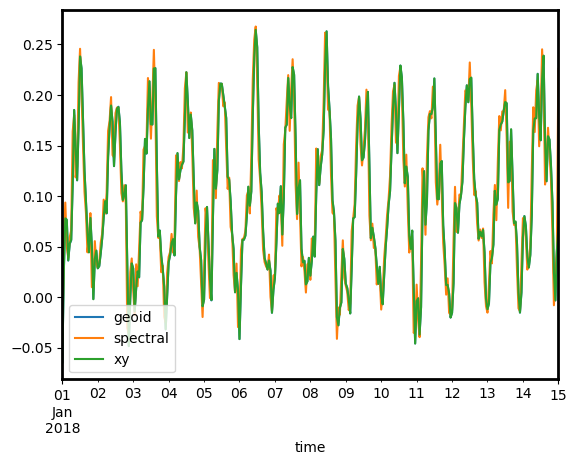

In [10]:
df["velocity_east"].plot(label="geoid")
df_sp["velocity_east"].plot(label="spectral")
df_xy["velocity_east"].plot(label="xy")
plt.legend()

---

## concatenate multiple trajectories and manipulate

In [9]:
ids = [0, 1, 2]
u_wave = [0, 0.1, 0.2]
dfm = (
    pd.concat(
        [
            generate_one_trajectory(u_mean=-0.1, v_mean=0, u_wave=uw, noise=0.05, id=id)
            for id, uw in zip(ids, u_wave)
        ]
    )
    .reset_index()
    .set_index("id")
)

# get all drifter ids
ids = list(dfm.index.unique())

dfm.head()

,time,lon,lat
id,,,
0,2018-01-01 00:00:00,-19.994509,29.999095
0,2018-01-01 01:00:00,-19.990376,30.001650
0,2018-01-01 02:00:00,-19.987246,30.000888
0,2018-01-01 03:00:00,-19.985878,30.000751
0,2018-01-01 04:00:00,-19.983250,30.000606


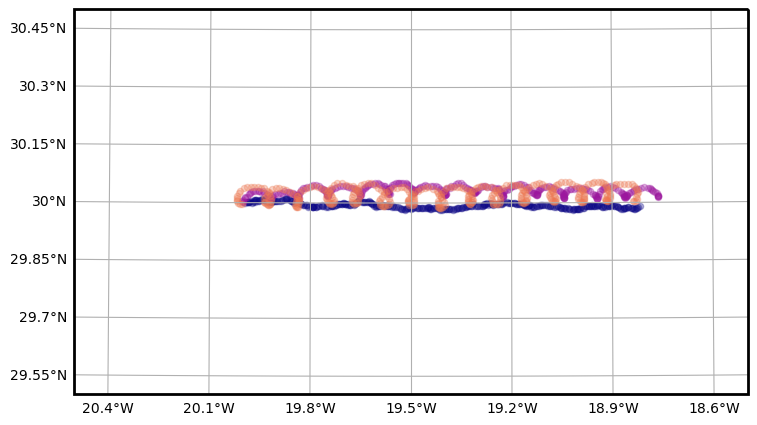

In [10]:
fig, ax, _ = pin.maps.plot_map(extent=[-20.5, -18.5, 29.5, 30.5])

colors = pin.get_cmap_colors(len(ids))

for i, c in zip(ids, colors):
    dfm.loc[i].plot.scatter(
        ax=ax, x="lon", y="lat", c=c, alpha=0.3, transform=pin.maps.crs
    )

Compute velocities and averaged energy per drifter

In [11]:
dfm_vel = (
    dfm.groupby("id")
    .apply(lambda df: df.set_index("time").geo.compute_velocities().reset_index())
    .droplevel(1)
)

<Axes: xlabel='id'>

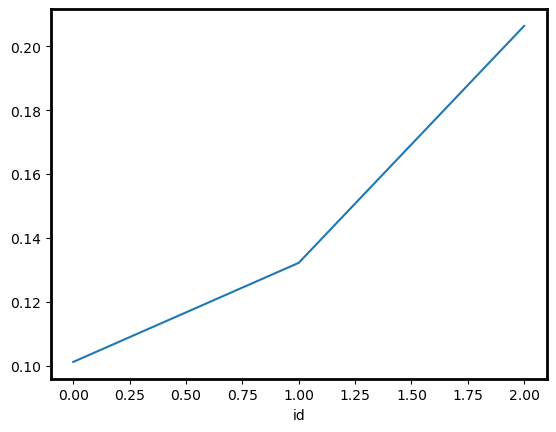

In [12]:
dfm_vel.groupby("id")["velocity"].mean().plot()

---

## compute window averaged diagnostics (spectra, autocorrelations)

In [13]:
...

Ellipsis

---

## denoise/despike time series

In [14]:
...

Ellipsis